#  MRI Tumor Classification Model

To practice my newly learned machine learning skills, I built an **image classification model** that classifies brain tumors from MRI images.  

I used a dataset from Kaggle, which can be found here:  
🔗 [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

Throughout this project, I explored several of Python’s powerful libraries for machine learning and image processing. To keep the code organized and reusable, I wrote many parts as **functions**, even if they weren’t all executed in a `main` function. This made the workflow cleaner and allowed for flexibility in experimenting with different models.  

I structured the code so that **different models can be trained effortlessly**, making it easy to experiment and compare performance.  

Overall, I really enjoyed this project and I’m proud of the results. I hope you enjoy !


In [20]:
# Importing libraries needed for model
import numpy as np
print("Imported numpy")
import pandas as pd
print('Imported pandas')
import matplotlib.pyplot as plt
print('Imported matplot')
import tensorflow as tf
print('Imported tf')
import cv2
print('Imported cv')
import os
print('Imported os')
import random

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image


Imported numpy
Imported pandas
Imported matplot
Imported tf
Imported cv
Imported os


In [21]:
train_data_dir = 'data/Training'
test_data_dir = 'data/Testing'
data_dir = 'data'
file_types = ['jpeg','png', 'bmp','jpg'] # Image file types I am allowing

In [22]:
def clean_images():
    # Function that cleans image_data, loops through folders in data then loops through the image and ensures the image is the correct extension otherwise
    # it removes the image from the dir
    for image_class in os.listdir(data_dir):
        if image_class != '.DS_Store':
            for image in os.listdir(os.path.join(data_dir, image_class)):

                image_path = os.path.join(data_dir, image_class, image)
                if image != '.DS_Store':
                    try:
                        image = cv2.imread(image_path)
                        with Image.open(image_path) as img:
                            tip = img.format.lower()
                        if tip not in file_types:
                            print("Image not in ext list".format(image_path))
                            print(f"Removing: {image_path}")
                            os.remove(image_path)

                    except Exception as e:
                        print("Issue with image{}".format(image_path))


In [23]:
def load_train_data(path , img_size):
    # Function that loads data into a training set and a validation set with a 80/20 ratio
    train_ds = tf.keras.utils.image_dataset_from_directory(path, image_size = (img_size, img_size), batch_size =32, 
                                                       label_mode = 'int', validation_split = 0.2, subset = 'training', seed = 123)
    valid_ds = tf.keras.utils.image_dataset_from_directory(path, image_size = (img_size, img_size), batch_size =32, 
                                                       label_mode = 'int', validation_split = 0.2, subset = 'validation', seed = 123)
    return train_ds, valid_ds

def load_test_data(path, img_size):
    test_ds = tf.keras.utils.image_dataset_from_directory(path, image_size = (img_size, img_size), batch_size =32, 
                                                       label_mode = 'int')
    
    return test_ds

def normalize_data(data):
    # Normalizes rgb values "0-255" by dividing them by 255. Makes the values range from 0.0 to 1.0, this will make our model learn a lot faster
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return data.map(lambda x, y: (normalization_layer(x), y))

In [24]:
train_ds, val_ds = load_train_data(train_data_dir, 256)
test_ds = load_test_data(test_data_dir, 256)

class_names = train_ds.class_names
num_classes = len(class_names)

print("\nProjects different classes: ")
for class_ in class_names:
    print(f"- {class_}")

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.

Projects different classes: 
- glioma
- meningioma
- notumor
- pituitary


In [25]:
train_ds = normalize_data(train_ds)
val_ds = normalize_data(val_ds)
test_ds = normalize_data(test_ds)

In [26]:
def build_model(num_layers, starting_unit, dropout):
    # Function that builds a convolution neural net with Pooling layers and Dense layers
    image_model = Sequential([layers.Conv2D(starting_unit, 3, activation='relu', input_shape=(256, 256, 3)), # Increased filters
    layers.MaxPooling2D()])

    loop_units = starting_unit
    for i in range(1, num_layers):
        image_model.add(layers.Conv2D(loop_units, 3, activation = 'relu'))
        image_model.add(layers.MaxPooling2D())
        loop_units = loop_units * 2

    image_model.add(layers.Flatten())
    image_model.add(layers.Dense(128, activation='relu'))
    image_model.add(layers.Dropout(dropout))
    image_model.add(layers.Dense(num_classes, activation='softmax'))
    image_model.summary()
    return image_model

def compile_model(model ,lr):
    # Function that compiles a model and takes model and learning rate (lr) as arguments
    model.compile(loss = SparseCategoricalCrossentropy(), 
                       optimizer = Adam(learning_rate = lr),
                       metrics = ['accuracy'])
    
def train_model(model ,train, validation, epochs):
    # Function that trains a CNN model with earlystopping and reudce lr
    earlystopping = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, monitor = 'val_loss')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 3, monitor = 'val_loss')

    model.fit(train, epochs = epochs, validation_data = validation,
            callbacks =[earlystopping, reduce_lr])


def assemble_model(num_layers, starting_units, dropout, lr, epochs):
    # Function that combines previous functions to easily create models, customizable by taking layers , starting units , dropouts and lr as arguments
    image_model = build_model(num_layers, starting_units, dropout)
    compile_model(image_model, lr)
    train_model(image_model, train_ds, val_ds, epochs)
    return image_model

image_model = assemble_model(3, 64, 0.5, 0.001, 30)

/Users/kellanmcintosh/Desktop/Git_Portfolio/DataSciencePortfolio/mri_model/mri-venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,858,820 (56.68 MB)

 Trainable params: 14,858,820 (56.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 109s 756ms/step - accuracy: 0.6698 - loss: 0.7978 - val_accuracy: 0.7706 - val_loss: 0.5368 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 109s 765ms/step - accuracy: 0.8186 - loss: 0.4696 - val_accuracy: 0.8546 - val_loss: 0.3968 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 756ms/step - accuracy: 0.8711 - loss: 0.3381 - val_accuracy: 0.9019 - val_loss: 0.2906 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 756ms/step - accuracy: 0.9031 - loss: 0.2584 - val_accuracy: 0.9151 - val_loss: 0.2517 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 744ms/step - accuracy: 0.9302 - loss: 0.1862 - val_accuracy: 0.9308 - val_loss: 0.2195 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 752ms/step - accuracy: 0.9466 - loss: 0.1443 - val_accuracy: 0.9081 - val_loss: 0.2958 - learning_rate: 0.0010
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 753ms/step - accura

In [28]:
def get_results(model, dataset):
    # Function that takes a model and a dataset (val , test or train) and stores the output in 4 different variables
    y_true = []
    y_pred = []
    confidence = []
    images = []
    
    for batch_images, batch_labels in dataset:
        pred = model.predict(batch_images, verbose = 0)
        class_pred = np.argmax(pred, axis = 1)
        confid = np.max(pred, axis =1)
        labels = batch_labels.numpy()
    
        y_pred.extend(class_pred)
        y_true.extend(labels)
        confidence.extend(confid)
        images.extend(batch_images.numpy())

    return y_true, y_pred, confidence, images

#Training set results
tr_label, tr_pred, tr_confidence, tr_image_list = get_results(image_model, train_ds)
#Validation set results
val_label, val_pred, val_confidence, val_image_list = get_results(image_model, val_ds)
# Test set results
test_label, test_pred, test_confidence, test_image_list = get_results(image_model, test_ds)


2025-09-01 11:53:14.786011: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set accuracy: 99.29978118161925% 
 Validation set accuracy: 94.48336252189142% 
 Test set accuracy: 93.74523264683448%
Accuracy: 0.9374523264683448


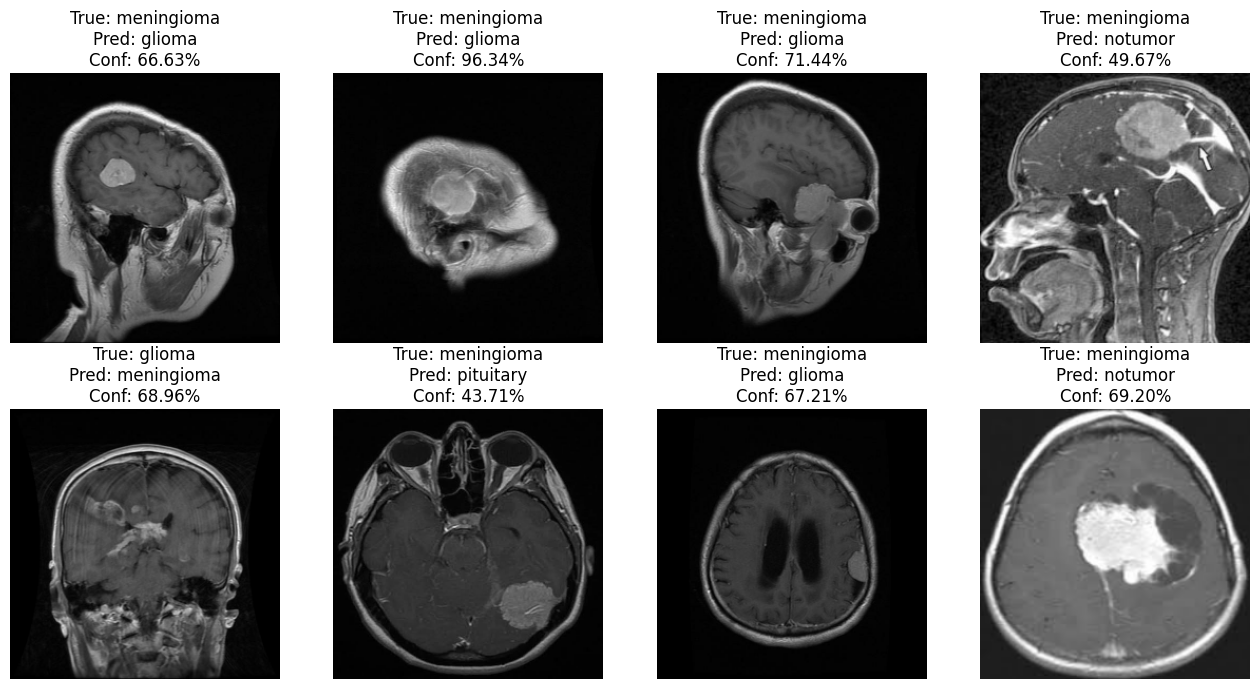

In [30]:
def get_accuracy(true, pred):
    # Function that returns the accuracy by seeing how often the prediction matches the actual label
    true = np.array(true)
    pred = np.array(pred)
    accuracy = np.mean(true == pred)

    return accuracy

tr_set_acc = get_accuracy(tr_label, tr_pred)
val_set_acc = get_accuracy(val_label, val_pred)
test_set_acc = get_accuracy(test_label, test_pred)
print(f"Training set accuracy: {tr_set_acc * 100}% \n Validation set accuracy: {val_set_acc * 100}% \n Test set accuracy: {test_set_acc * 100}%")

def error_analysis(true , prediction, con_level, images):
    # Error analysis function that helps to visualize where the model seems to be going wrong, we do this by displaying examples it incorrectly predicted
    
    acc = get_accuracy(true, prediction)
    
    print(f"Accuracy: {acc}")
    
    y_true = np.array(true)
    y_pred = np.array(prediction)
    confidence = np.array(con_level)
    images_list = np.array(images)
    
    error_idx = np.where(y_pred != y_true)[0]
    

    n_rows = 2
    n_cols = 4
    fig , axes = plt.subplots(nrows= n_rows, ncols= n_cols, figsize=(n_cols * 4 , n_rows * 4))
    axes = axes.flatten()

    for i, idx in enumerate(error_idx[:n_rows * n_cols]):
        true_label = class_names[true[idx]]  
        pred_label = class_names[prediction[idx]]  
        confidence_score = confidence[idx]
        
        axes[i].imshow(images_list[idx])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence_score*100:.2f}%")
        axes[i].axis("off")

error_analysis(test_label, test_pred, test_confidence, test_image_list)


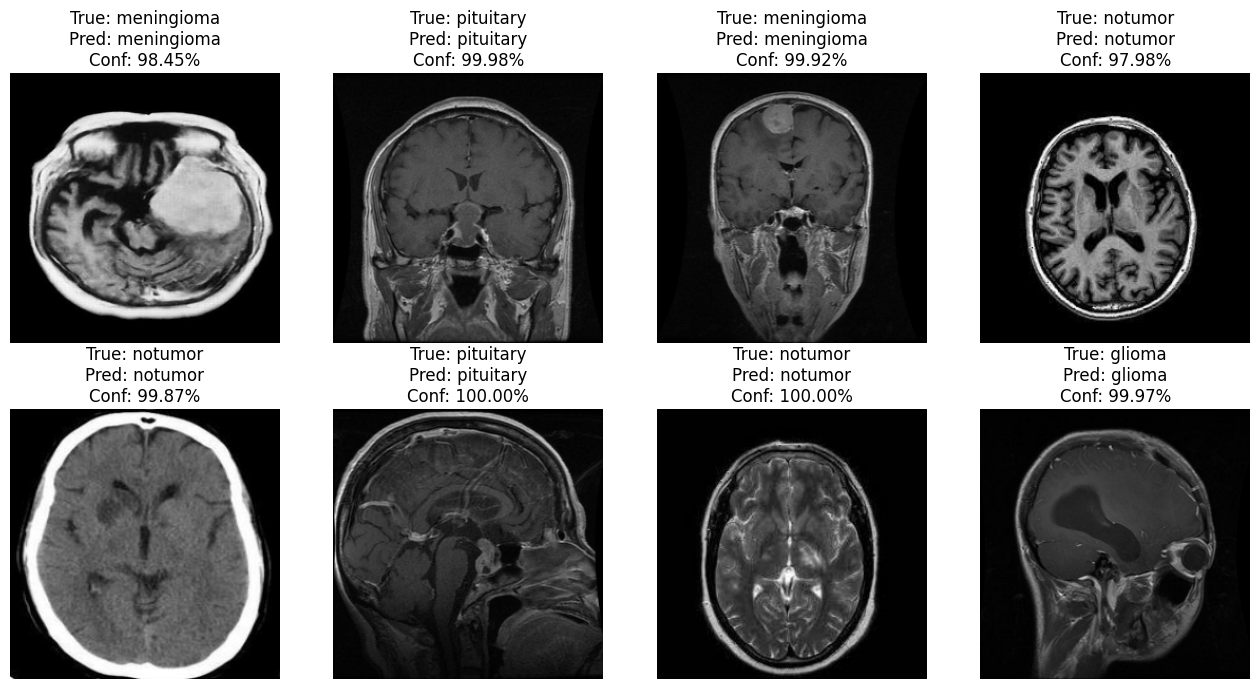

In [31]:
def access_random_sample(true , prediction, con_level, images, sample_size):
    # Function that randomly selects samples to visualize, this is just to see some examples of the model making predictions
    roof = len(images)
    random_indices = np.random.randint(low = 0, high = roof, size = sample_size)

    true_label = np.array(true)
    pred_label = np.array(prediction)
    confidence = np.array(con_level)
    images_list = np.array(images)

    n_rows = 2
    n_cols = 4
    fig , axes = plt.subplots(nrows= n_rows, ncols= n_cols, figsize=(n_cols * 4 , n_rows * 4))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        true_label = class_names[true[idx]]  
        pred_label = class_names[prediction[idx]]  
        confidence_score = confidence[idx]
        
        axes[i].imshow(images_list[idx])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence_score*100:.2f}%")
        axes[i].axis("off")

access_random_sample(test_label, test_pred, test_confidence, test_image_list, 8)

In [32]:
# Saving train model to access again in the future without having to train the model
image_model.save('/Users/kellanmcintosh/Desktop/Git_Portfolio/DataSciencePortfolio/mri_model/saved_models/tumor_classification_model.keras')

Accuracy: 0.9448336252189142


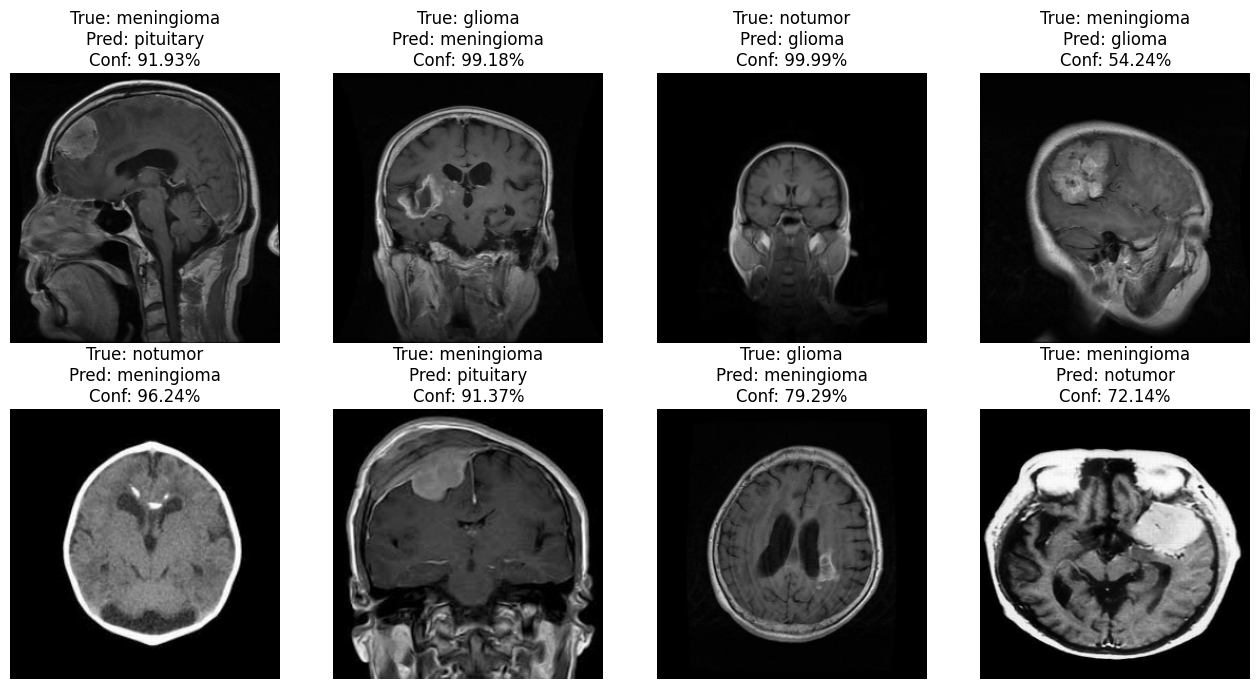

In [33]:
# Testing to make sure it saved correctly and can be reused
imported_model = tf.keras.models.load_model('/Users/kellanmcintosh/Desktop/Git_Portfolio/DataSciencePortfolio/mri_model/saved_models/tumor_classification_model.keras')
val_label, val_pred, val_confidence, val_image_list = get_results(imported_model, val_ds)

error_analysis(val_label, val_pred, val_confidence, val_image_list)

# MRI Tumor Classification Model Results

For my first image classification project, I achieved **93% accuracy** on the test set, a result I am more than happy with. This model, built to classify tumors in MRI brain scans using the [Kaggle Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

## Key Achievements
- **High Accuracy**: The model’s 93% accuracy on the test set reflects that the model performs really well on classifying tumors from MRI images and the wide use of libraries to create this model shows my understanding of machine learning techniques and knowledge of the libraries.
- **Code Reusability**: I designed the project with modularity in mind, structuring the code into reusable functions for data preprocessing, model training, and evaluation. This makes it easy to adapt the codebase for future image recognition projects, saving time and effort in future development.

## Thanks!
Thank you for taking the time to look through my project
